# Machine Learning Engineer Nanodegree
## Unsupervised Learning
## Project: Creating Customer Segments

Welcome to the third project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

> Since I built two environments for python, checking if the notebook is using version 2.7

In [249]:
import sys
sys.version_info

sys.version_info(major=2, minor=7, micro=12, releaselevel='final', serial=0)

## Getting Started

In this project, you will analyze a dataset containing data on various customers' **annual spending amounts** (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to **best describe the variation in the different types of customers that a wholesale distributor interacts with.** Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

Run the code block below to load the wholesale customers dataset, along with a few of the necessary Python libraries required for this project. You will know the dataset loaded successfully if the size of the dataset is reported.

In [332]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualizations code visuals.py
import visuals as vs
import matplotlib.pyplot as plt


# Import model and metrics

from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
from sklearn.mixture import GMM
from sklearn.metrics import silhouette_score

# Pretty display for notebooks
%matplotlib inline

In [251]:
# Load the wholesale customers dataset
try:
    data = pd.read_csv("./customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print "Wholesale customers dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

Wholesale customers dataset has 440 samples with 6 features each.


## Data Exploration
In this section, you will begin exploring the data through visualizations and code to understand how each feature is related to the others. You will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which you will track through the course of this project.

Run the code block below to observe a statistical description of the dataset. Note that the dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**. Consider what each category represents in terms of products you could purchase.

Before run summary on columns, always take a peak at the data to get a lay of the land. 

In [252]:
data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


In [253]:
# data is actually quite small
data.shape

(440, 6)

The numeric value of the data represents the annual spending one user had on one of the six product categories. 

In [254]:
# Display a description of the dataset
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. In the code block below, add **three** indices of your choice to the `indices` list which will represent the customers to track. It is suggested to try different sets of samples until you obtain customers that vary significantly from one another.

In [255]:
# TODO: Select three indices of your choice you wish to sample from the dataset
indices = [27, 99, 187]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print "Chosen samples of wholesale customers dataset:"
display(samples)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,14276,803,3045,485,100,518
1,9658,2182,1909,5639,215,323
2,2438,8002,9819,6269,3459,3


### Question 1
Consider the total purchase cost of each product category and the statistical description of the dataset above for your sample customers.  
*What kind of establishment (customer) could each of the three samples you've chosen represent?*  
**Hint:** Examples of establishments include places like markets, cafes, and retailers, among many others. Avoid using names for establishments, such as saying *"McDonalds"* when describing a sample customer as a restaurant.

A good way to tackle this problem would be write a function that plot our sample data points against a summary of population distribution.

In [256]:
max(data.max())

112151

In [257]:
def plt_samples_boxplot(pop_df, sample_df):
    """ function to compare sampled customers' spend against population
    """
    df_cols = pop_df.columns.tolist()
    clr_lst = ['ro', 'bo', 'go', 'r+', 'b+', 'g+']
    spend = []
    
    for i in range(0,len(sample_df)):
        spend.append(sample_df.iloc[i].tolist())
        
    plt.figure(1, figsize = (14,11))
    axes = plt.gca()
    # axes.set_xlim([-min(pop_df.min())*100,max(pop_df.max())])
    _ = pop_df.boxplot(df_cols, return_type='dict', vert=False)
    
    for i in range(0, len(sample_df)):
        plt.plot(spend[i], range(1,7), clr_lst[i])

    plt.show()

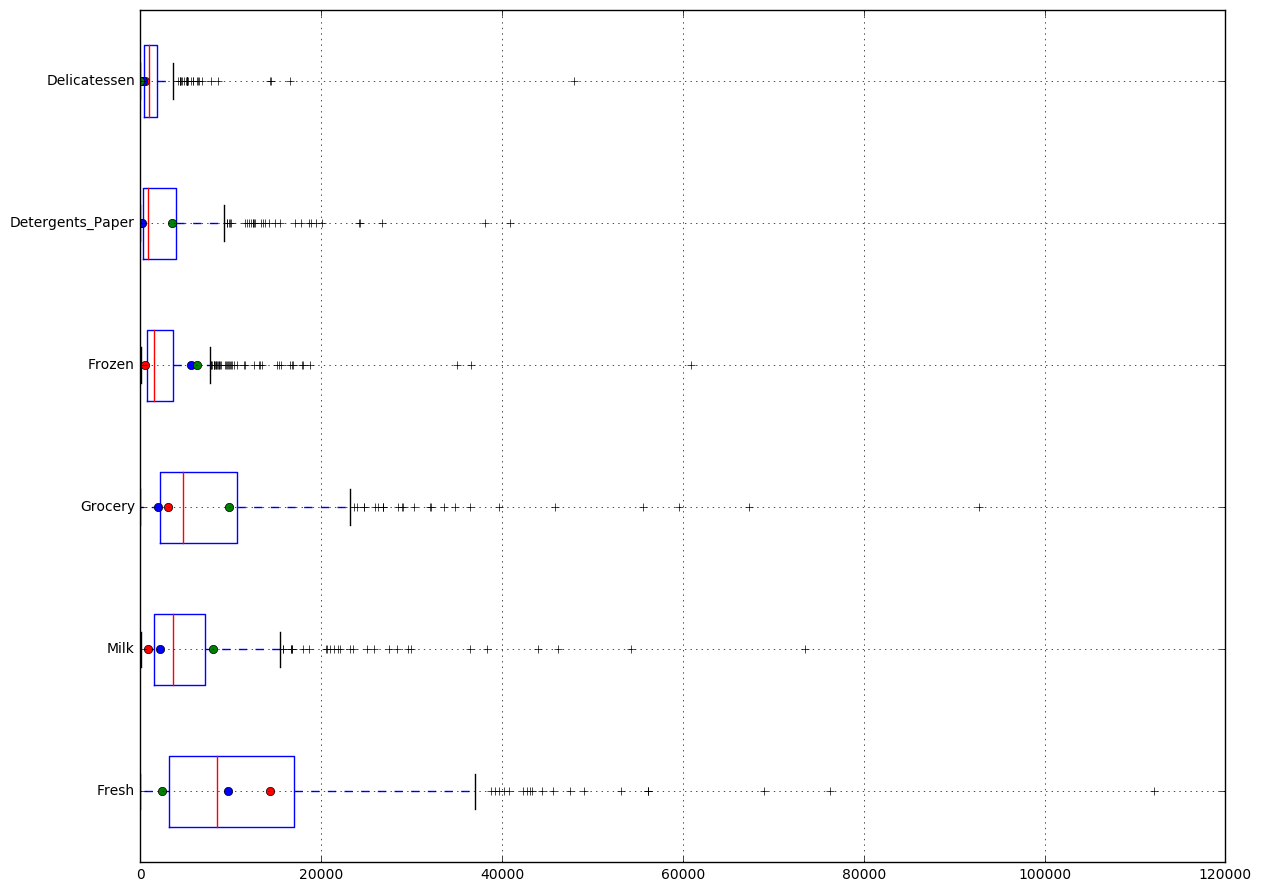

In [258]:
plt_samples_boxplot(data, samples)

# NOTE: boxplot shows all features distribution is highly right skewed, will fix that later with log transformation

> **Answer:**

Three sampled customers in my plot is represented by **red, blue, green** dots and they are plotted against the full data distribution on different product categories. 

**Customer 1 (Red Dots)**

Customer 1 differ from other in high values of fresh products purchase, some grocery purhcase, low milk and frozen food purchase. This suggests that this customer could likely be a restaurant that needs a large quantity of produce and grocery for cooking. 


**Customer 2 (Blue Dots)**

Customer 2 has higher than median level of fresh foods, lower level of milk and grocery and also very high values of forzen foods (above 75% percentile), which gives me the impression that it's either a small diner/cafe that serves froze + fresh foods, or a small grocery stores that sell fresh produce and vegetatble. 

**Customer 3 (Green Dots)**

Customer 3 has lower than 25 percentile of the fresh food purchases, above 75 percentile milk, grocery, frozen food and also high detergents papers. Therefore, I hypothesize that this is actually a grocery store. 

### Implementation: Feature Relevance
One interesting thought to consider is if **one (or more) of the six product categories is actually relevant for understanding customer purchasing.** That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In the code block below, you will need to implement the following:
 - Assign `new_data` a copy of the data by removing a feature of your choice using the `DataFrame.drop` function.
 - Use `sklearn.cross_validation.train_test_split` to split the dataset into training and testing sets.
   - Use the removed feature as your target label. Set a `test_size` of `0.25` and set a `random_state`.
 - Import a decision tree regressor, set a `random_state`, and fit the learner to the training data.
 - Report the prediction score of the testing set using the regressor's `score` function.

In [259]:
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [260]:
# TODO: Make a copy of the DataFrame, using the 'drop' function to drop the given feature
new_data = data.drop(['Grocery'], axis = 1, inplace = False)
label = data['Grocery']

# TODO: Split the data into training and testing sets using the given feature as the target
X_train, X_test, y_train, y_test = train_test_split(new_data, label, test_size=0.25, random_state=0)

# TODO: Create a decision tree regressor and fit it to the training set
regressor = DecisionTreeRegressor(random_state=729)
regressor.fit(X_train, y_train)

# TODO: Report the score of the prediction using the testing set
score = regressor.score(X_test, y_test)

print "the score of the prediction using the testing set is {}".format(score)

the score of the prediction using the testing set is 0.63719128607


### Question 2
*Which feature did you attempt to predict? What was the reported prediction score? Is this feature is necessary for identifying customers' spending habits?*  
**Hint:** The coefficient of determination, `R^2`, is scored between 0 and 1, with 1 being a perfect fit. A negative `R^2` implies the model fails to fit the data.

**Answer:**

I tried to predict `Grocery` features, because I feel this category is too broad and could be easily correlated with other categories (you could almost argue other cateogry could also be purchased and put under grocery category). 

The prediction score is 0.63719128607, which indicates our regressor did a fair job in predicting the values of Grocery, because the predicted score is closer to 1 than 0, which means it's much better than random. 

But I would argue `Grocery` is a necessary feature for identifying customers' spending habits, for that there are about 37% variance in customers' Grocery purchase habits can't be explained collectively by other features, which means `Grocery` features contributes a decent amount variablity in defining customers purchase patent. 

> But what is the feature that contribute the least? Let's see... 


In [261]:
def get_drop_score(feature):

    new_df = data.drop([feature], axis = 1, inplace = False)
    drop_label = data[feature]

    # TODO: Split the data into training and testing sets using the given feature as the target
    X_train, X_test, y_train, y_test = train_test_split(new_df, drop_label, test_size=0.25, random_state=0)

    # TODO: Create a decision tree regressor and fit it to the training set
    regressor = DecisionTreeRegressor(random_state=729)
    regressor.fit(X_train, y_train)

    # TODO: Report the score of the prediction using the testing set
    score = regressor.score(X_test, y_test)

    return score

for col_name in data.columns:
    print col_name, get_drop_score(col_name)

Fresh -0.293643591135
Milk 0.114817550187
Grocery 0.63719128607
Frozen 0.14552300177
Detergents_Paper 0.731664643488
Delicatessen -11.9408712414


It looks like `Detergents_Paper` is the least neccessary features because it can be predicted by other features pretty well. `Grocery` is the second least neccessary one, so I made a decent effort in choosing a possibly dispensable feature. 

`Fresh` and `Delicatessen` is probably the most independent and neccessary features, because judging by the score, other features just can't predict them at all _(The scatterplot matrix in the next section should agree with the modeling results as well)._

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. Run the code block below to produce a scatter matrix.

It would make sense to bring more quantifiable metrics to determine the strength of the correlation rather just eyeballing it. Therefore, modified the scatterplot matrix to overlay the actual correlation coefficient. 

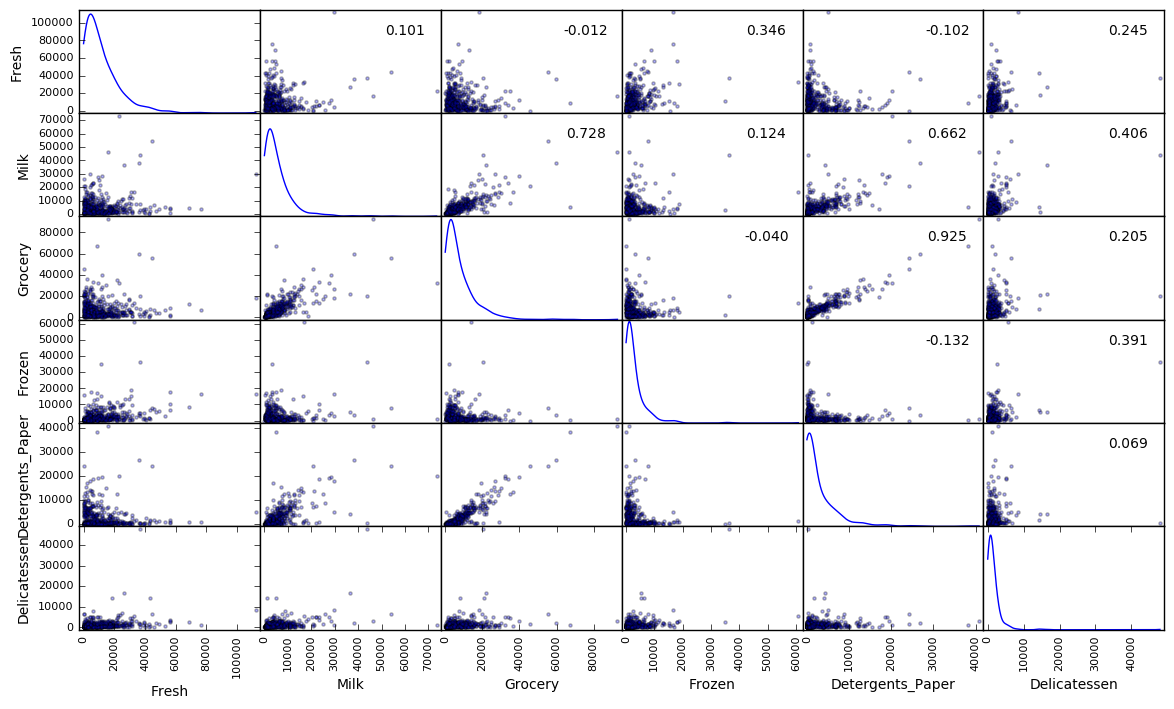

In [262]:
# Produce a scatter matrix for each pair of features in the data
axes = pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');
corr = data.corr().as_matrix()
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')
plt.show()

### Question 3
*Are there any pairs of features which exhibit some degree of correlation? Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? How is the data for those features distributed?*  
**Hint:** Is the data normally distributed? Where do most of the data points lie? 

> **Answer:**

**1) Tops 3 Feature Pairs that exhibits correlation (descending according to the correlation coef)**

`Grocery` and `Detergents_Paper` (0.925 corr coeff). 
`Grocery` and `Milk` (0.728 corr coeff)
`Detergents_Paper` and `Milk` (0.662 corr coeff) 

**2) Compare the modeling results:**

Descriptive correlation agrees with our modeling results closely. 

Looking at first row (Fresh) and last row (Delicatessen) where we can't find any pair-wise scatter plot that shows a linear relationship. Fresh row data all squeezed in the lower left corner and expends to all direction. Delicatessen row scatterplot are all flat and can't possibly be correlated with other variables. 

However, looking at Detergents_Paper column, immediatly we see two linear relationship in its scatterplots, and Detergents_Paper appeared twice in the top three strongest pair-wise correlations. Same conclusion could be drawn when looking at the Grocery column where there are two highly correlated pair-wise relationship that make this feature predicable with other variable collectively. 

**3) Features distribution skewness:**

Multiple visualization from the beginning, the boxplots that all squeezed to the left of the plot and the density plot in the scatterplot matrix demenstrate a highly right-skewed distributed features, where most customer have a relatively low monetary values from different categories.  

## Data Preprocessing
In this section, you will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.

### Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

In the code block below, you will need to implement the following:
 - Assign a copy of the data to `log_data` after applying logarithmic scaling. Use the `np.log` function for this.
 - Assign a copy of the sample data to `log_samples` after applying logarithmic scaling. Again, use `np.log`.

In [263]:
np.log(samples+0.01)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,9.566336,6.688367,8.021259,6.184170,4.605270,6.249995
1,9.175543,7.688002,7.554340,8.637464,5.370685,5.777683
2,7.798937,8.987448,9.192076,8.743374,8.148738,1.101940


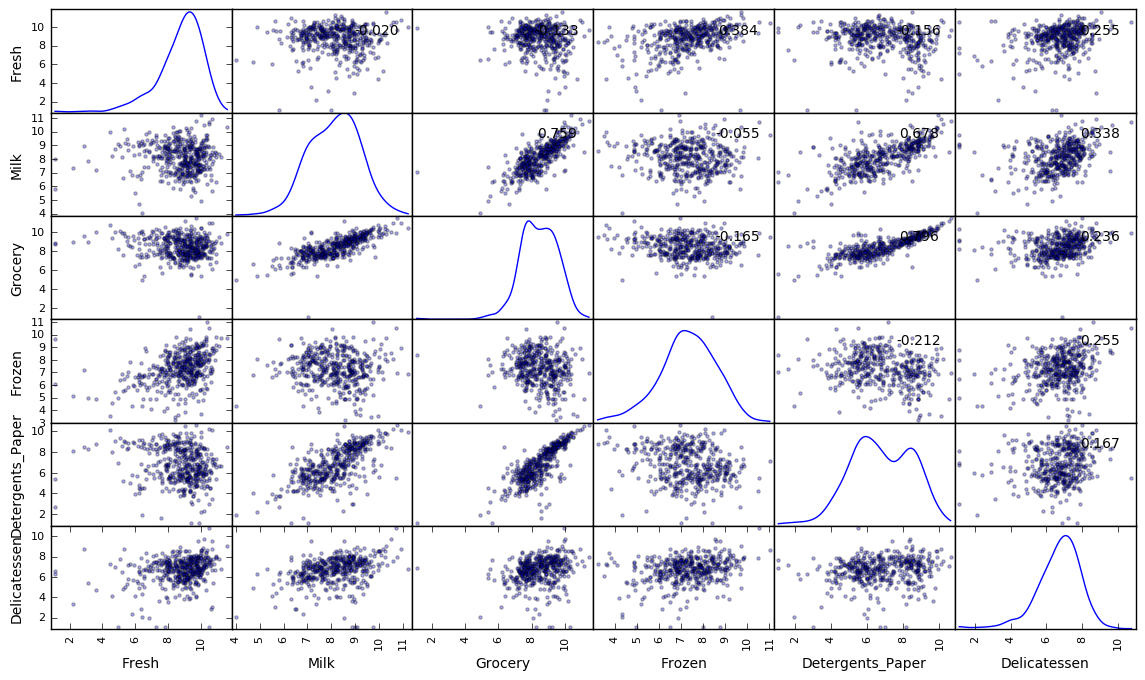

In [264]:
# TODO: Scale the data using the natural logarithm
log_data = np.log(data+0.01)

# TODO: Scale the sample data using the natural logarithm
log_samples = np.log(samples+0.01)

# Produce a scatter matrix for each pair of newly-transformed features
# pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

axes = pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');
corr = log_data.corr().as_matrix()
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')
plt.show()

After the feature scaling, our previous boxplots will not all be squeezed to the left and thus much more easier to compare the samples data's relative location in the population distribution. 

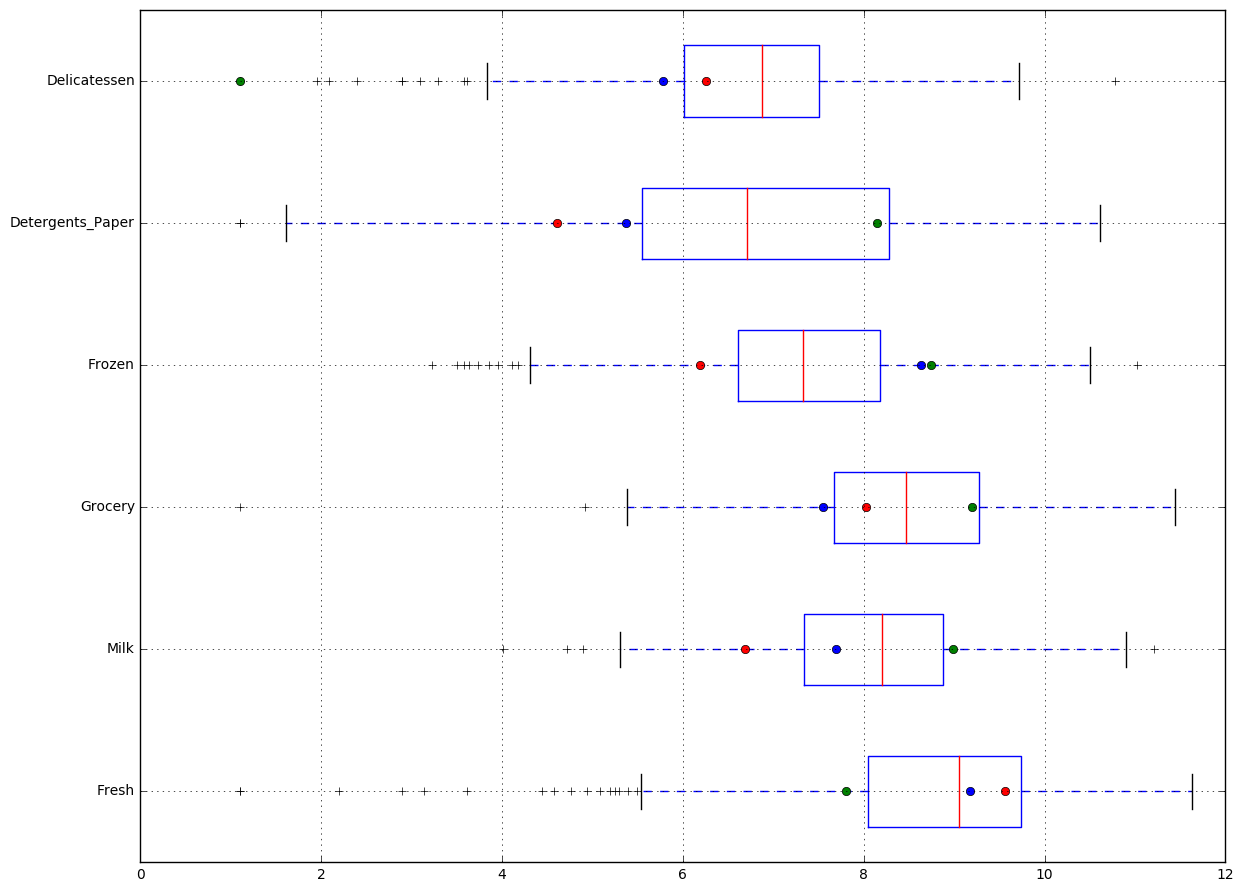

In [265]:
plt_samples_boxplot(log_data, log_samples)

# knew that function will be useful somewhere 

### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features you may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

Run the code below to see how the sample data has changed after having the natural logarithm applied to it.

> log transformation didn't change the direction of the correlation, it's still there for sure. Visually, the correlation seems to become more obvious. _(corr coeff increase a little bit too)_

In [266]:
# Display the log-transformed sample data
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,9.566336,6.688367,8.021259,6.184170,4.605270,6.249995
1,9.175543,7.688002,7.554340,8.637464,5.370685,5.777683
2,7.798937,8.987448,9.192076,8.743374,8.148738,1.101940


### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the code block below, you will need to implement the following:
 - Assign the value of the 25th percentile for the given feature to `Q1`. Use `np.percentile` for this.
 - Assign the value of the 75th percentile for the given feature to `Q3`. Again, use `np.percentile`.
 - Assign the calculation of an outlier step for the given feature to `step`.
 - Optionally remove data points from the dataset by adding indices to the `outliers` list.

**NOTE:** If you choose to remove any outliers, ensure that the sample data does not contain any of these points!  
Once you have performed this implementation, the dataset will be stored in the variable `good_data`.

In [267]:
outliers  = []

# For each feature find the data points with extreme high or low values
for feature in log_data.keys():
    col = log_data.get(feature)
    
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(col, 25)
    
    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(col, 75)
    
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5*(Q3 - Q1)
    
    # Display the outliers
    outlier_df = log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))]
    outliers.extend(outlier_df.index)
    
    print "{} Data points considered outliers for the feature '{}':".format(len(outlier_df), feature)
    display(outlier_df)

# OPTIONAL: Select the indices for data points you wish to remove

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

16 Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.442769,9.950324,10.732651,3.583797,10.095388,7.260530
66,2.198335,7.335641,8.911531,5.164843,8.151336,3.296207
81,5.389117,9.163250,9.575192,5.645482,8.964185,5.049920
95,1.101940,7.979342,8.740658,6.086797,5.407217,6.563870
96,3.135929,7.869406,9.001840,4.976803,8.262045,5.379943
128,4.941714,9.087835,8.248793,4.955897,6.967919,1.101940
171,5.298367,10.160530,9.894245,6.478525,9.079435,8.740338
193,5.193012,8.156226,9.917982,6.865902,8.633733,6.501305
218,2.890927,8.923193,9.629380,7.158522,8.475748,8.759670
304,5.081466,8.917312,10.117510,6.424885,9.374414,7.787386


4 Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.039984,11.205014,10.377048,6.894680,9.906982,6.805734
98,6.220610,4.718588,6.656739,6.796835,4.025530,4.882878
154,6.432956,4.007515,4.920054,4.317621,1.947338,2.080691
356,10.029504,4.897914,5.384541,8.057381,2.198335,6.306294


2 Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923193,7.036157,1.101940,8.390952,1.101940,6.882448
154,6.432956,4.007515,4.920054,4.317621,1.947338,2.080691


10 Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431855,9.663262,9.723703,3.496811,8.847361,6.070761
57,8.597299,9.203619,9.257893,3.637849,8.932214,7.156184
65,4.442769,9.950324,10.732651,3.583797,10.095388,7.260530
145,10.000569,9.034082,10.457143,3.737908,9.440738,8.396157
175,7.759192,8.967633,9.382107,3.951436,8.341889,7.436623
264,6.978223,9.177715,9.645041,4.111038,8.696178,7.142835
325,10.395650,9.728182,9.519736,11.016479,7.148354,8.632130
420,8.402009,8.569028,9.490016,3.219276,8.827323,7.239222
429,9.060332,7.467377,8.183121,3.850360,4.430936,7.824450
439,7.932725,7.437212,7.828042,4.174541,6.167537,3.951436


2 Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923193,7.036157,1.101940,8.390952,1.10194,6.882448
161,9.428191,6.291588,5.645482,6.995775,1.10194,7.711106


14 Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.198335,7.335641,8.911531,5.164843,8.151336,3.296207
109,7.248511,9.724900,10.274569,6.511760,6.728641,1.101940
128,4.941714,9.087835,8.248793,4.955897,6.967919,1.101940
137,8.034958,8.997148,9.021841,6.493769,6.580653,3.583797
142,10.519646,8.875149,9.018333,8.004703,2.996232,1.101940
154,6.432956,4.007515,4.920054,4.317621,1.947338,2.080691
183,10.514530,10.690808,9.911952,10.505999,5.476505,10.777768
184,5.789991,6.822208,8.457445,4.304200,5.811171,2.398804
187,7.798937,8.987448,9.192076,8.743374,8.148738,1.101940
203,6.368204,6.529433,7.703464,6.150624,6.860674,2.890927


In [268]:
print "there are {} data points in the original data.".format(len(log_data))
print "Afer outlier removal, there are {} data points in the original data.".format(len(good_data))

there are 440 data points in the original data.
Afer outlier removal, there are 398 data points in the original data.


### Question 4
*Are there any data points considered outliers for more than one feature based on the definition above? Should these data points be removed from the dataset? If any data points were added to the `outliers` list to be removed, explain why.* 

First find those outliers that got identified with more than one categories:

In [269]:
from collections import Counter 
# use counter to find dupe in list here is probably an overkill, but this is the easiest I know. 

hvy_outliers = [k for k,v in Counter(outliers).items() if v>1]
log_data.iloc[hvy_outliers]

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
128,4.941714,9.087835,8.248793,4.955897,6.967919,1.101940
154,6.432956,4.007515,4.920054,4.317621,1.947338,2.080691
65,4.442769,9.950324,10.732651,3.583797,10.095388,7.260530
66,2.198335,7.335641,8.911531,5.164843,8.151336,3.296207
75,9.923193,7.036157,1.101940,8.390952,1.101940,6.882448


**Answer:**

The data points that prove to be outliers in multiple categories are listed above. I believe before conducting PCA, those outliers should be remove from the data set to make sure the reconstruction of the data is not affect by outliers. When performing PCA, we want the alogrithm to reconstruct the underlying variance in the data, so that it will generalize well and help us understand better about the latent variables in the data. If we still include the outliers, they will be taken into consideration by PCA to construct the principles. Outliers will distort/stretch those principle components to make them capture the rare flunctuations in the data. 

## Feature Transformation
In this section you will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In the code block below, you will need to implement the following:
 - Import `sklearn.decomposition.PCA` and assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

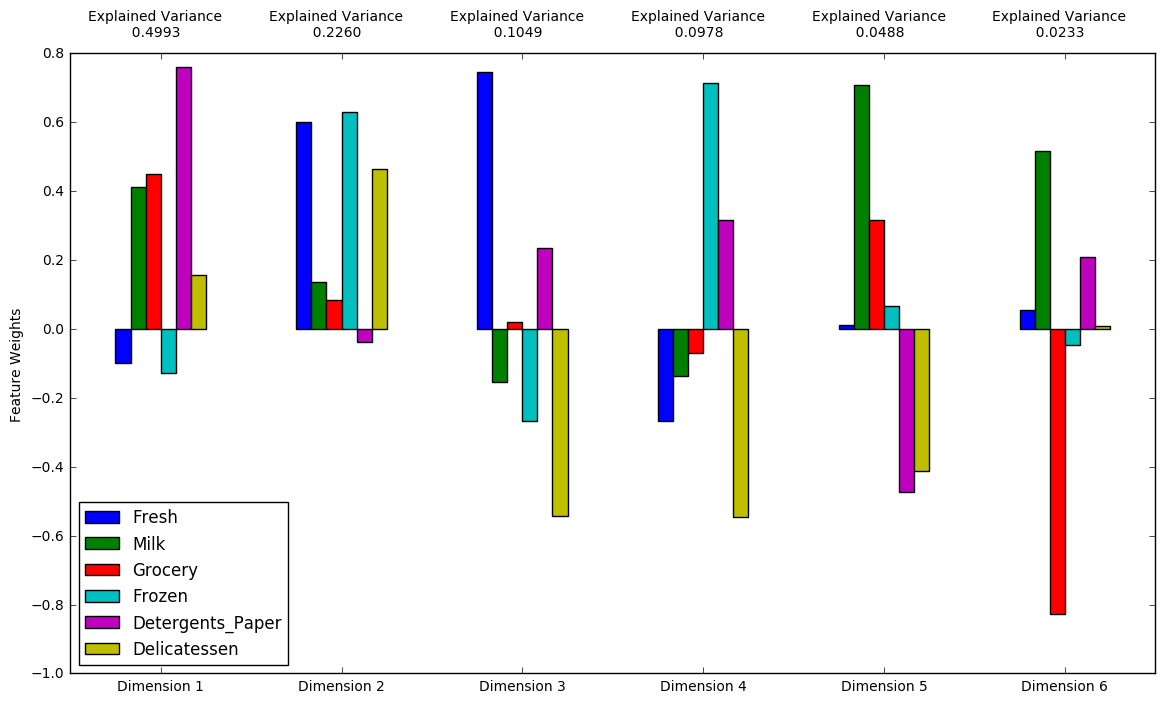

In [276]:
# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components=6)
pca.fit(good_data)

# TODO: Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = vs.pca_results(log_data, pca)

Let's plot some results! 

In [277]:
pca_results

,Explained Variance,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Dimension 1,0.4993,-0.0976,0.4109,0.4511,-0.1280,0.7595,0.1579
Dimension 2,0.2260,0.6008,0.1370,0.0852,0.6300,-0.0376,0.4634
Dimension 3,0.1049,0.7453,-0.1544,0.0204,-0.2672,0.2348,-0.5421
Dimension 4,0.0978,-0.2665,-0.1375,-0.0709,0.7132,0.3157,-0.5447
Dimension 5,0.0488,0.0114,0.7083,0.3168,0.0671,-0.4729,-0.4120
Dimension 6,0.0233,0.0543,0.5177,-0.8267,-0.0471,0.2081,0.0094


In [278]:
pca.explained_variance_ratio_

array([ 0.49930274,  0.22595189,  0.10488372,  0.09781669,  0.04878967,
        0.02325529])

### Question 5
*How much variance in the data is explained* ***in total*** *by the first and second principal component? What about the first four principal components? Using the visualization provided above, discuss what the first four dimensions best represent in terms of customer spending.*  
**Hint:** A positive increase in a specific dimension corresponds with an *increase* of the *positive-weighted* features and a *decrease* of the *negative-weighted* features. The rate of increase or decrease is based on the indivdual feature weights.

**Answer:**

The first and second PCs explained about **72.53%** of the total variance, and **92.8%** from the first four PCs combined. 

First four PCs represent the main archetypes of the customer spendings in the data, specifically: 

1) 1st PC represents customers who spend heavily on Milk, Grocery and Detergents Papers, and low in Fresh and Deli categories, which indicates those customers could be a large grocery store or retail chains. 

2) 2nd PC represents customers who spend heavily on Fresh, Frozen and Delicateseen, but low on Detergents Papers and Grocery, which suggests those customers could be a cafe or diner. _(I will explains the loading difference between diner and restaurants in next point)_

3) 3rd PC represents customers who spend heavily on Fresh, Delicateseen and Frozen, but low on Detergents Papers (absolute loading on Deli is high on the 3rd PC even its actual value is negative). These loadings suggest that it could well be a restaurant, because compare to the 2nd PC, it has more Fresh and more Deli but a lot less Frozen food spendin. In general, I would assume that restaurants are more likely to use fresh produce for cooking. 

4) 4th PC load heavily on Frozen food, Deli and Detergents Papers, but really low on Fresh food and Grocery. I would guess those customers are small grocery stores, like those 7-11s, which stores more Frozen foods and other groceries items. 

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. Consider if this is consistent with your initial interpretation of the sample points.

In [281]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,-2.4148,-0.8076,0.8039,-1.2202,0.0420,-0.7796
1,-1.9839,0.3526,0.1290,1.0282,0.5949,0.1421
2,0.7814,-2.3616,2.0943,4.5997,2.6379,-0.0847


### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — **in effect, reducing the complexity of the problem.** Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the **cumulative explained variance ratio** is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, you will need to implement the following:
 - Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `good_data` using `pca.transform`, and assign the results to `reduced_data`.
 - Apply a PCA transformation of `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [286]:
# TODO: Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=2)
pca.fit(good_data)

# TODO: Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# TODO: Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [287]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,-2.4148,-0.8076
1,-1.9839,0.3526
2,0.7814,-2.3616


## Visualizing a Biplot
A biplot is a scatterplot where each data point is represented by its scores along the principal components. The axes are the principal components (in this case `Dimension 1` and `Dimension 2`). In addition, the biplot shows the projection of the original features along the components. A biplot can help us interpret the reduced dimensions of the data, and discover relationships between the principal components and original features.

Run the code cell below to produce a biplot of the reduced-dimension data.

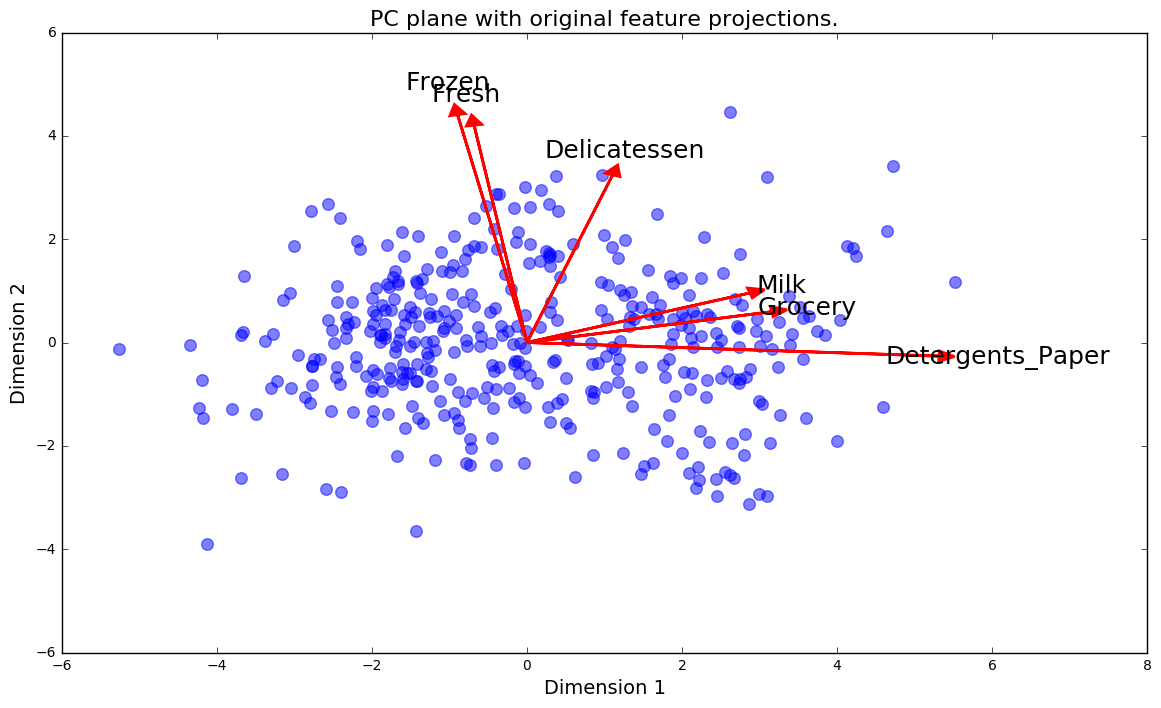

In [288]:
# Create a biplot
vs.biplot(good_data, reduced_data, pca)

### Observation

Once we have the original feature projections (in red), it is easier to interpret the relative position of each data point in the scatterplot. For instance, a point the lower right corner of the figure will likely correspond to a customer that spends a lot on `'Milk'`, `'Grocery'` and `'Detergents_Paper'`, but not so much on the other product categories. 

From the biplot, which of the original features are most strongly correlated with the first component? What about those that are associated with the second component? Do these observations agree with the pca_results plot you obtained earlier?

## Clustering

In this section, you will choose to use either a **K-Means clustering algorithm** or a **Gaussian Mixture Model clustering algorithm** to identify the various customer segments hidden in the data. You will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Question 6
*What are the advantages to using a K-Means clustering algorithm? What are the advantages to using a Gaussian Mixture Model clustering algorithm? Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?*

**Answer:**

One of the greatest advantages of K-means clustering to me is its efficiency, simplicity, and interpretability, comparing to other un-supervised clustering algorithm. In that sense, I kind treat K-means clustering as the logistic regression of classification problem. For me, first applying K-means clustering to a clustering problem is the most intuitive clustering method for me to establish more understanding of the underlying data and clustering problem. 

To be more precise, the advantages K-means holds can be summarised as follow:

**1)** K-means clustering is fast, due to its linear complexity. Therefore, as the data grow, the querying time will only increase linearly.

**2)** K-means clustering is reltatively intuitive, making it easy to understand and easy to interpret

**3)** Also we have to point out that K-means' biggest limitation would probably be the process of select the approriate k is not the most straightforward and would almost makes k-means cluster "semi-unsupervised". 

On the other hand, advantages of using Gaussian Mixture Model (GMM) clustering algorithm lies in the following: 

**1)** Cluster assignment in GMM is a lot more flexible than K-means. K-means only produce spherical clusters, where GMM is able to produce clusters in a number of different shapes.

![](./sphx_glr_plot_gmm_covariances_0011.png)

_(reference this chart from [sklearn documentation](http://scikit-learn.org/stable/modules/mixture.html))_

**2)** Due to the probablistic EM, GMM model accommodates mixed membership, whereas K-means would only allows for mutually exclusive cluster membership. In K-means, one point will belongs to only one cluster, but in GMM, points belong to different clusters to a different degrees. 

**3)** In the discussion of comparing K-means with GMM, I have to mention that K-means is just a specific case of GMM. 


----

After reading more about the differences of the two alogrithms, I think the most appropriate algorithm for our data is GMM. The biggest reason is that through PCA, we realize that our data has some hidden and un-observable parameters. Using GMM, algorithm is assigning a probability to each point to belong to certain cluster, instead of "hard code" cluster membership like K-Means. This way we have more flexibility of GMM to arrive an optimal clustering solution. 

Also, another important reason is that since our data size is small, the major advantange of k-means being a simple and fast algorithm is not necessarily advantageous here over GMM. 


### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, you will need to implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import `sklearn.metrics.silhouette_score` and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

Judging by `silhouette coefficient`, how many clusters do we need, try 2 through 5. 

In [338]:
for i in range(2,6):
    clusterer = GMM(n_components=i, n_iter = 50)
    clusterer.fit(reduced_data)
    preds = clusterer.predict(reduced_data)
    score = silhouette_score(reduced_data, preds, metric='euclidean')
    
    print "using {} clusters, achieving silhouette_score of {}".format(i, score)

using 2 clusters, achieving silhouette_score of 0.44360355115
using 3 clusters, achieving silhouette_score of 0.357297450616
using 4 clusters, achieving silhouette_score of 0.291649272167
using 5 clusters, achieving silhouette_score of 0.268399419251


It seems we should only use **2** clusters for our reduced data with GMM. 

In [339]:
# TODO: Apply your clustering algorithm of choice to the reduced data 
clusterer = GMM(n_components=2, n_iter = 50)
clusterer.fit(reduced_data)

# TODO: Predict the cluster for each data point
preds = clusterer.predict(reduced_data)

# TODO: Find the cluster centers
centers = clusterer.means_

# TODO: Predict the cluster for each transformed sample data point
sample_preds = clusterer.predict(pca_samples)

# TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
score = silhouette_score(reduced_data, preds, metric='euclidean')
print score

0.44360355115


### Question 7
*Report the silhouette score for several cluster numbers you tried. Of these, which number of clusters has the best silhouette score?* 

**Answer:**

Please see above where I first tried 2 - 5 clusters before deciding how many clusters to use. It turns out 2 clusters produce the best sihouette score about **0.4436**

### Cluster Visualization
Once you've chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, you can now visualize the results by executing the code block below. Note that, for experimentation purposes, you are welcome to adjust the number of clusters for your clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters. 

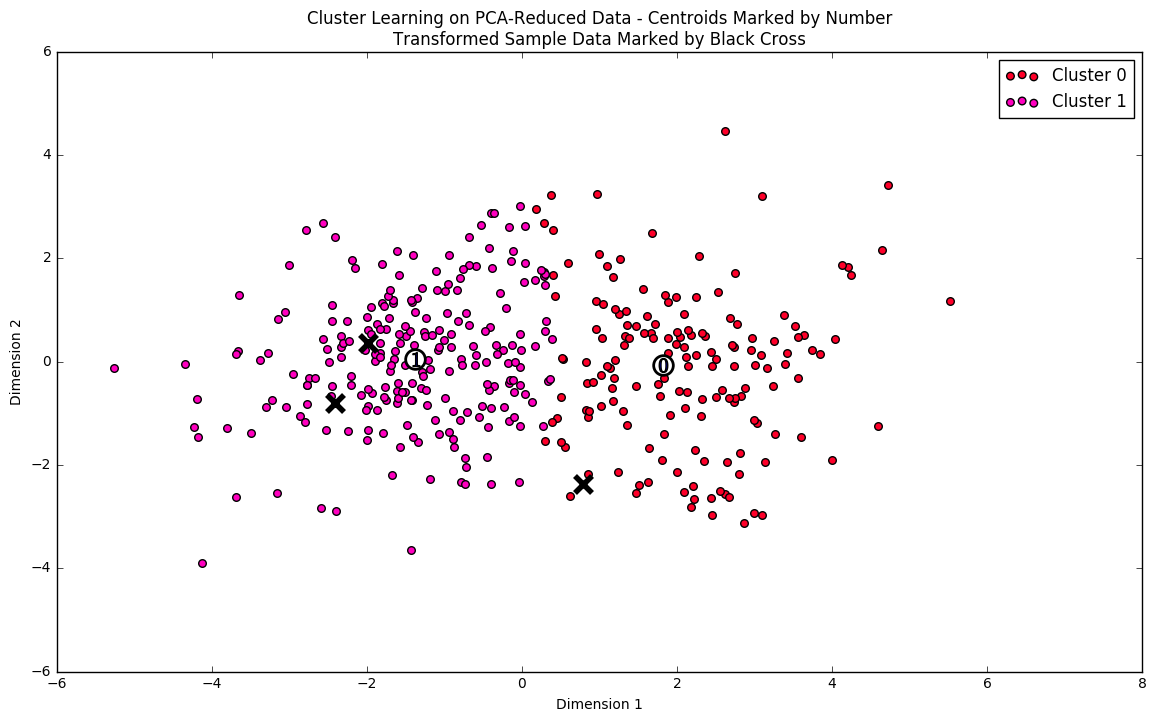

In [331]:
# Display the results of the clustering from implementation
vs.cluster_results(reduced_data, preds, centers, pca_samples)

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. **Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.**

In the code block below, you will need to implement the following:
 - Apply the inverse transform to `centers` using `pca.inverse_transform` and assign the new centers to `log_centers`.
 - Apply the inverse function of `np.log` to `log_centers` using `np.exp` and assign the true centers to `true_centers`.


In [340]:
# TODO: Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# TODO: Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,6079.0,7042.0,10241.0,1275.0,3545.0,1159.0
Segment 1,8967.0,1919.0,2437.0,2082.0,309.0,741.0


### Question 8
Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project. *What set of establishments could each of the customer segments represent?*  
**Hint:** A customer who is assigned to `'Cluster X'` should best identify with the establishments represented by the feature set of `'Segment X'`.

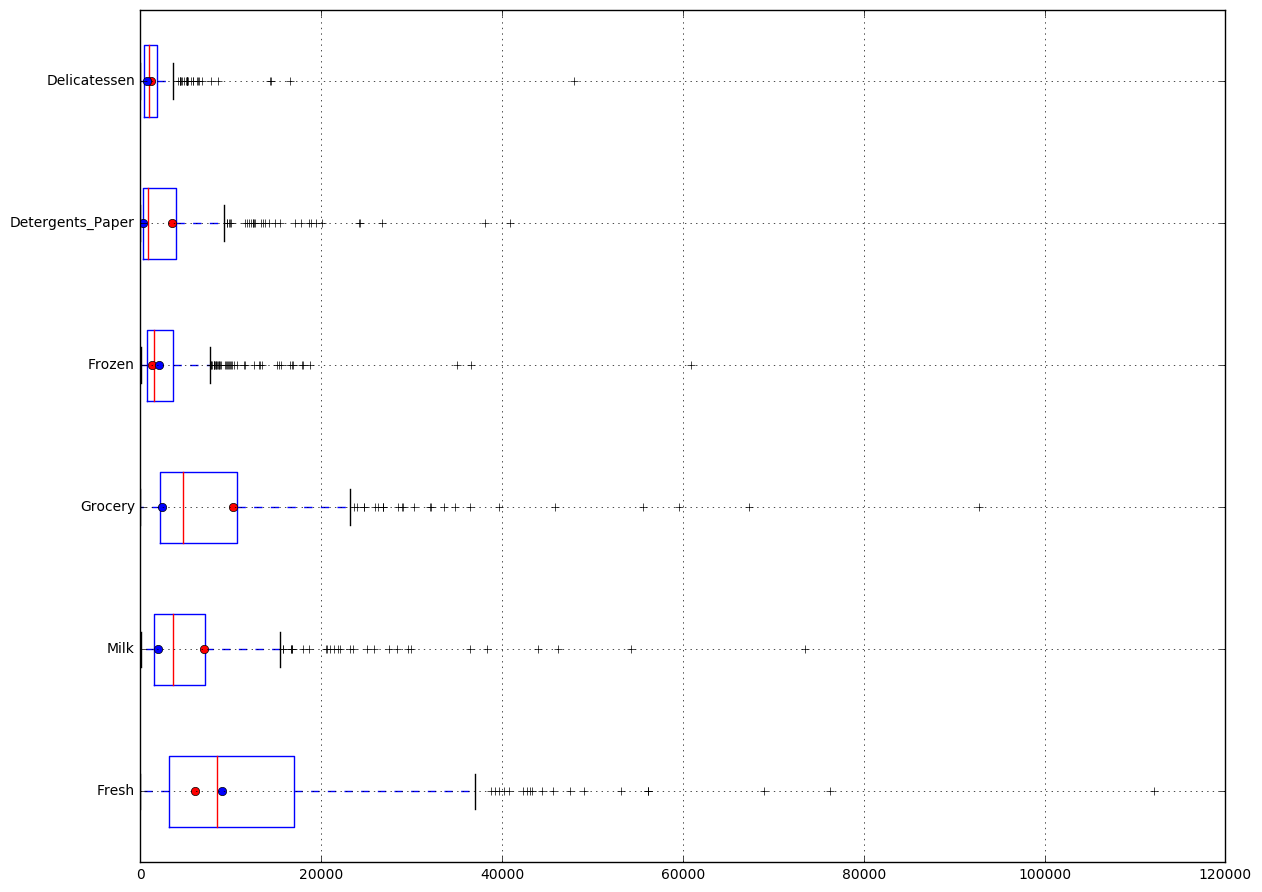

In [341]:
# Time to use the function above for visual inspection:

plt_samples_boxplot(data, true_centers)

**Answer:**

Looking at the visual above we notice that cluster center 1 (red) and cluster center 2 (blue) are positioned at the left and right of mean of every category spending, which makes it easy to understand the establishment they represents. 

**1) Cluster 1 (red)** 

High spending on: Milk, Grocery, Detergents_Papers and Deli
Low spending on: Fresh and Frozen food. 

This segment represents establishments that don't process a lot of food, they might store and sell it, thus they are more likly to be grocery stores. 

**2) Cluster 2 (blue)** 

High spending on: Fresh and Frozen food.
Low spending on: Milk, Grocery, Detergents_Papers and Deli.

This segment represents establishments that process a lot of fresh and frozen food, thus they are most likely to be restaurants. 


### Question 9
*For each sample point, which customer segment from* ***Question 8*** *best represents it? Are the predictions for each sample point consistent with this?*

Run the code block below to find which cluster each sample point is predicted to be.

In [342]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print "Sample point", i, "predicted to be in Cluster", pred

Sample point 0 predicted to be in Cluster 1
Sample point 1 predicted to be in Cluster 1
Sample point 2 predicted to be in Cluster 0


**Answer:**

Recall in question 1 and 2, based on the spending paterns of customer 1, 2 and 3, I hypothesized that customer 1 is a small restaurant, diner or cafe. Customer 2 is a bigger restaurant, and customer 3 is a grocery store. 

It turns out the prediction of their cluster membership (customer 1 and 2 in cluster 1, customer 3 in cluster 0) is consitent with my previous hypothesis. 

## Conclusion

In this final section, you will investigate ways that you can **make use of the clustered data.** First, you will consider how the different groups of customers, the ***customer segments***, may be affected differently by a specific delivery scheme. Next, you will consider how giving a label to each customer (which *segment* that customer belongs to) can provide for additional features about the customer data. Finally, you will compare the ***customer segments*** to a hidden variable present in the data, to see whether the clustering identified certain relationships.

### Question 10
Companies will often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services to determine whether making that change will affect its customers positively or negatively. The wholesale distributor is considering changing its delivery service from currently 5 days a week to 3 days a week. However, the distributor will only make this change in delivery service for customers that react positively. *How can the wholesale distributor use the customer segments to determine which customers, if any, would react positively to the change in delivery service?*  
**Hint:** Can we assume the change affects all customers equally? How can we determine which group of customers it affects the most?

**Answer:**

I think the objective here is to design an experiment to evaluate the effectiveness of service switching. In randomized control trial, the only thing that is different in test and control group, should be the variable of interest, which is whether customer get treatment of 3 days a week delivery instead of 5 days a week. 

Our clustering revealed that there are at least two very distinct groups of customers in our data: restaurants and retailers, thus this can't be the variable in our test. So the test should only be conducted on the group that's most sensitive to the treatment. I would argue that group is the restaurant group, because the quality and freshness of their food should be one of their highest concern, thus they are most likely to react to the change of delivery service by changing their purchase behaviors. For the retailers, the change is too small to impact their purchase behavior. 

**Experiment set up:**

For only the customers in the restaurant group, randomly split them into control and test groups where:

1) control group - Business as usual (BAU) 5 day delivery service.

2) test group - More frequent delivery of 3 day delivery service. 

Next step, after obtain the results data, find a KPI that could approximate the purchase behavior, and using independent two sample t test to see if the more frequent delivery had an effect over the restaurant segment. 

### Question 11
Additional structure is derived from originally unlabeled data when using clustering techniques. Since each customer has a ***customer segment*** it best identifies with (depending on the clustering algorithm applied), we can consider *'customer segment'* as an **engineered feature** for the data. Assume the wholesale distributor recently acquired ten new customers and each provided estimates for anticipated annual spending of each product category. Knowing these estimates, the wholesale distributor wants to classify each new customer to a ***customer segment*** to determine the most appropriate delivery service.  
*How can the wholesale distributor label the new customers using only their estimated product spending and the* ***customer segment*** *data?*  
**Hint:** A supervised learner could be used to train on the original customers. What would be the target variable?

**Answer:**

This is a classic example where we use un-supervised learning to discover the hidden information in the data, in this case it is the customer segments, and we treat that variable as the target variable for supervised learning. In this case, we identified two segments of customers, which could be used as a class label that we use as a target varaible to train a classifier to predict new customer. 

Once this wholesale distributor obtain new data, they can use the classifier to predict new customer's customer segment labels and then compare that to the "segment profile" we established during the segmentation. 

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.

Run the code block below to see how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, you will find the sample points are circled in the plot, which will identify their labeling.

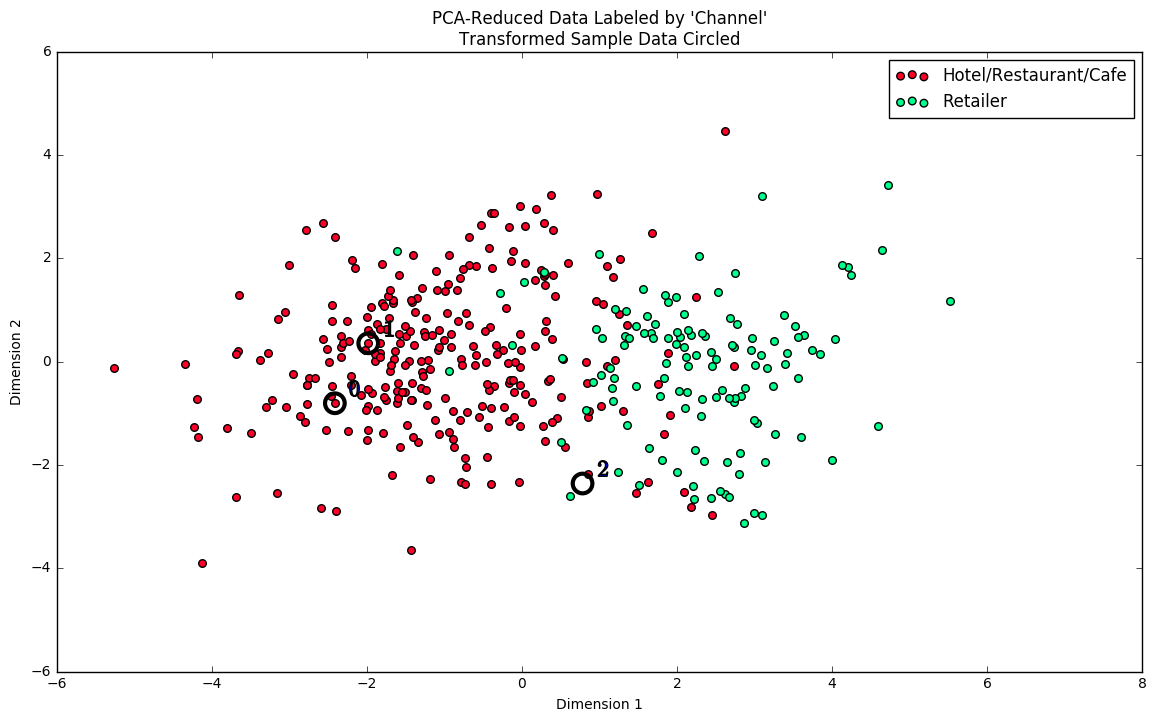

In [344]:
# Display the clustering results based on 'Channel' data
vs.channel_results(reduced_data, outliers, pca_samples)s

### Question 12
*How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? Would you consider these classifications as consistent with your previous definition of the customer segments?*

**Answer:**

The GMM clustering algorithm does a pretty good job approximate the underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers, judging by the two clustering visualizations are very close. Three sample are all clustered correctly, although the third example I picked seems happened to be closer to the cluster bondary. 

The second question seems to be a little bit vague, but here is what I think it wants to ask:

If we treat the channel variable as the "true clustering", comparing to our clustering via GMM, there are some customer that belong purely to one cluster. They are the ones that to the farther right and left in the visuals, far from the cluster bondary. In GMM, they are the ones that will get assigned a high probablity of belonging to one cluster, thus I consider them as pure. However, close to the cluster bondary, we also see some mixture of the clusters, eg, some Retailer are deep in the Hotel/Restaurant/Cafe cluster and vise versa. Those are the ones that will be assigned by GMM to belong to either cluster to a similar degree. 

Judging by the above, I would consider these classifications as consistent with my previou



> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.